In [5]:
import os
import json
import math
import argparse
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from detectron2.structure import BoxMode

In [6]:
parser = argparse.ArgumentParser(description='Plothole Segmentation')
parser.add_argument("--path", type=str, default=os.path.join(os.getcwd(), "data"), help="Path to the data directory")
parser.add_argument("--split", type=str, default="train", help="Target directory (train, test, val)", choices=["train", "test", "val"])
parser.add_argument("--target", type=str, default="images", help="Target directory (images, videos)", choices=["images", "videos"])
args = parser.parse_args(args=[])

In [7]:
path = args.path
if not os.path.exists(path):
    raise ValueError(f"Path {path} does not exist")

In [8]:
path = os.path.join(path, args.target, args.split)
if not os.path.exists(path):
    raise ValueError(f"Path {path} does not exist")

imagePath = os.path.join(path, "images")
labelsPath = os.path.join(path, "labels")

In [9]:
trainImage = sorted(os.listdir(imagePath))
trainLabels = sorted(os.listdir(labelsPath))

if len(trainImage) != len(trainLabels):
    raise ValueError(f"Number of images and labels do not match")

for i in range(len(trainImage)):
    trainImage[i] = trainImage[i][:-4]
    trainLabels[i] = trainLabels[i][:-4]

imageDF = pd.DataFrame({"imageFile": trainImage})
labelDF = pd.DataFrame({"labelFile": trainLabels})

trainDF = pd.merge(imageDF, labelDF, left_on="imageFile", right_on="labelFile", how="inner")

---

## Show segmentation mask (points) 

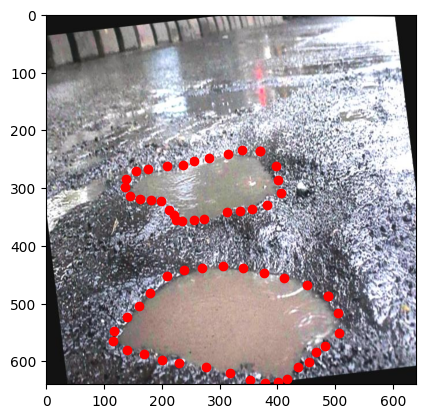

In [10]:
trainDF = trainDF.sample(frac=1).reset_index(drop=True)
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(imagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    #* 640 x 640
    xlim = math.ceil(image.shape[1])
    ylim = math.ceil(image.shape[0])

    with open(os.path.join(labelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            line = [float(line) for line in line.strip().split(" ")[1:]]
            xs, ys = [], []
            for i in range(len(line)):
                xs.append(line[i] * xlim) if i % 2 == 0 else ys.append(line[i] * ylim)
            plt.scatter(xs, ys, color="red")
    plt.show()
    break

---

## Get bounding box from segmentation mask (points) in COCO format

In [11]:
def seg_to_bbox(seg_info):
    _, *points = seg_info.strip().split()
    points = [float(p) for p in points]
    x_min, y_min, x_max, y_max = min(points[0::2]), min(points[1::2]), max(points[0::2]), max(points[1::2])
    return [x_min, y_min, x_max - x_min, y_max - y_min]

----

## Show bounding box

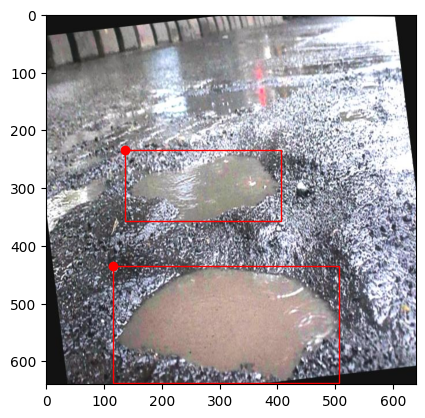

In [12]:
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(imagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    xlim = math.ceil(image.shape[1])
    ylim = math.ceil(image.shape[0])

    with open(os.path.join(labelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            bbox = seg_to_bbox(line)
            for i in range(len(bbox)):
                bbox[i] = bbox[i] * xlim if i % 2 == 0 else bbox[i] * ylim
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color="red")
            plt.scatter(bbox[0], bbox[1], color="red")
            plt.gca().add_patch(rect)
    plt.show()
    break

----

## Create COCO format label files

In [15]:

print(path)
cocoTrainPath = os.path.join(path, "cocoLabels.json")
coco = {"images": [], "annotations": [], "categories": [{"supercategory": "pothole", "id": 1, "name": "pothole"}]}

annID = 0
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(imagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    xlim = math.ceil(image.shape[1])
    ylim = math.ceil(image.shape[0])

    coco["images"].append({
        "id": row["imageFile"],
        "width": xlim,
        "height": ylim,
        "file_name": row["imageFile"] + ".jpg"
    })

    with open(os.path.join(labelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            bbox = seg_to_bbox(line)
            bbox = [p * xlim if i % 2 == 0 else p * ylim for i, p in enumerate(bbox)]

            seg = [float(p) for p in line.strip().split(" ")[1:]]
            seg = [p * xlim if i % 2 == 0 else p * ylim for i, p in enumerate(seg)]

            coco["annotations"].append({
                "id": annID,
                "image_id": row["imageFile"],
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "iscrowd": 0,
                "area": bbox[2] * bbox[3],
                "category_id": coco["categories"][0]["id"],
                "segmentation": [seg],
            })
            annID += 1
image = None
coco

/home/cati/Scrivania/Dev/PotholeSegmentation/data/images/train


{'image': [{'id': 'pic-155-_jpg.rf.a0f2c54c02aec34c0ca6138b4635c155',
   'width': 640,
   'height': 640,
   'file_name': 'pic-155-_jpg.rf.a0f2c54c02aec34c0ca6138b4635c155.jpg'},
  {'id': 'pic-234-_jpg.rf.c7c54a2bd8c106f1e8959e88238d0f3c',
   'width': 640,
   'height': 640,
   'file_name': 'pic-234-_jpg.rf.c7c54a2bd8c106f1e8959e88238d0f3c.jpg'},
  {'id': 'pic-179-_jpg.rf.c4a7f4f1cff2653d7d2fbc85d91bddca',
   'width': 640,
   'height': 640,
   'file_name': 'pic-179-_jpg.rf.c4a7f4f1cff2653d7d2fbc85d91bddca.jpg'},
  {'id': 'pic-25-_jpg.rf.2d988998b2a995bdee0f0282803e4801',
   'width': 640,
   'height': 640,
   'file_name': 'pic-25-_jpg.rf.2d988998b2a995bdee0f0282803e4801.jpg'},
  {'id': 'pic-137-_jpg.rf.5b5d603ae481652805ea93e3698ea609',
   'width': 640,
   'height': 640,
   'file_name': 'pic-137-_jpg.rf.5b5d603ae481652805ea93e3698ea609.jpg'},
  {'id': 'pic-199-_jpg.rf.08d902c95a9a00f33f6a031a3ce86eaf',
   'width': 640,
   'height': 640,
   'file_name': 'pic-199-_jpg.rf.08d902c95a9a00f33f6

In [14]:
with open(cocoTrainPath, "w") as f:
    json.dump(coco, f)